In [1]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import tensorflow.python.keras
import statistics
import seaborn as sns

In [2]:
dir = '../input/60k-stack-overflow-questions-with-quality-rate'

In [3]:
# join train and valid dataset
data = pd.concat(
    [
        pd.read_csv(f'{dir}/train.csv', index_col='Id'),
        pd.read_csv(f'{dir}/valid.csv', index_col='Id')
    ],
    axis=0
)

In [4]:
data.head()

,Title,Body,Tags,CreationDate,Y
Id,,,,,
34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [5]:
df = data.drop(columns=['Tags', 'CreationDate'])
df.shape

(60000, 3)

In [6]:
# joint title and body and drop them
df['Text'] = df['Title']+ " "+df['Body']
df = df.drop(columns=['Title', 'Body'])

In [7]:
# find maximum length of sentence
df['Words'] = df['Text'].apply(lambda x: len(x.split()))
# word less than 2 words
df[df['Words'] <= 1]

,Y,Text,Words
Id,,,


In [8]:
df.loc[df['Words'].idxmax()].Words

5420

In [9]:
# a simple strategy to choose the max length
WORD_LENS = df['Words'].tolist()
print('Maximum words: ', max(WORD_LENS))
print('Minimum words: ',min(WORD_LENS))
print('Median: ',statistics.median(WORD_LENS))

Maximum words:  5420
Minimum words:  8
Median:  88.0


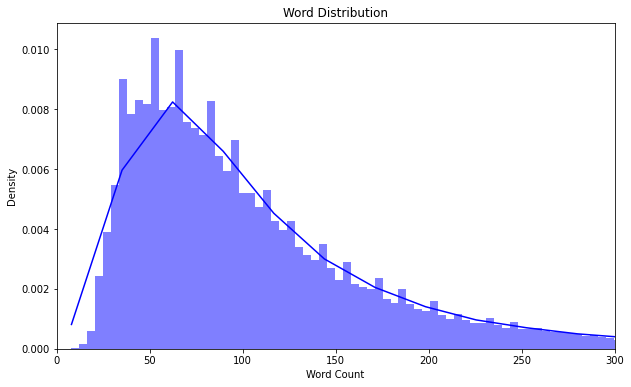

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(WORD_LENS, color='blue', kde=True, stat='density', linewidth=0)
plt.xlim([0, 300])
plt.xlabel('Word Count')
plt.title('Word Distribution')
plt.grid(False)
plt.savefig(f'EECSI_density.png', format='png', dpi=300)
plt.show()

In [11]:
MAX_LEN = 200

**Data Preprocessing**

In [12]:
!pip uninstall -y preprocessor
!pip uninstall -y tweet-preprocessor
!pip install tweet-preprocessor

In [13]:
import preprocessor as p

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [15]:
# load libraries
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [16]:
def cleaned(text):
    #change to lowercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    #lemmatize
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        word = p.clean(word)
        sentence.append(lemmatizer.lemmatize(word, 'v'))
    
    return ' '.join(sentence)

In [17]:
# cleaning
df['Cleaned'] = df['Text'].apply(lambda x : cleaned(x[:MAX_LEN]))

In [18]:
df[['Text','Cleaned']].head()

,Text,Cleaned
Id,,
34552656,Java: Repeat Task Every Random Seconds <p>I'm ...,java repeat task every random second pim alrea...
34553034,Why are Java Optionals immutable? <p>I'd like ...,java optionals immutable pid like understand j...
34553174,Text Overlay Image with Darkened Opacity React...,text overlay image darken opacity react native...
34553318,Why ternary operator in swift is so picky? <p>...,ternary operator swift picky pthe question sim...
34553755,hide/show fab with scale animation <p>I'm usin...,hideshow fab scale animation pim use custom fl...


In [19]:
!pip install WordCloud

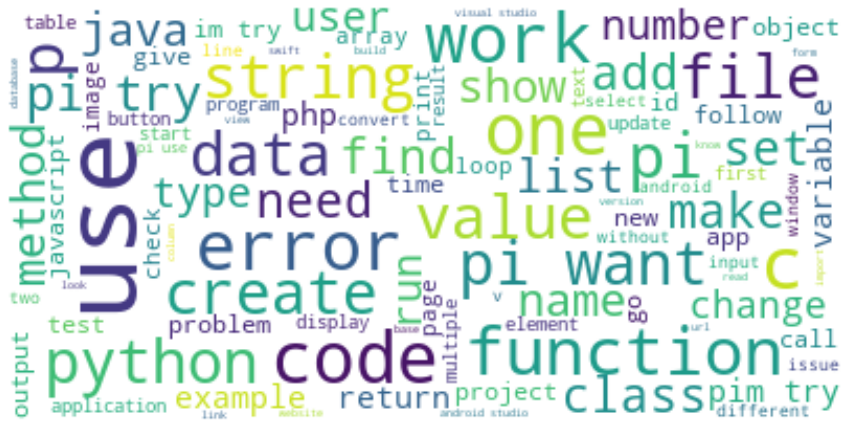

In [20]:
from wordcloud import WordCloud
text = " ".join(cat for cat in df['Cleaned'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig(f'EECSI_word-cloud.png', format='png', dpi=300)
plt.show()

**Data Transformation**

In [21]:
# encoding with https://huggingface.co/sentence-transformers
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=6c31c95e89f4fc77420277c5eabf2ac5cae7d6f400ca4a7db84253fefc42b086
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [22]:
from transformers import AutoTokenizer, AutoModel, TFBertModel, TFAutoModel

In [23]:
# tokenize with BERT
MODEL_NAME = 'sentence-transformers/paraphrase-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [24]:
encoding = tokenizer(
    text=df['Cleaned'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    max_length=MAX_LEN,
    truncation=True,
    pad_to_max_length=True,
    return_tensors='tf',
    verbose=True
)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
2022-08-06 11:58:39.989551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 11:58:39.990762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 11:58:39.991485: I ten

In [25]:
TOKENS = encoding['input_ids']

In [26]:
print('Sentence:')
print(df.iloc[3]['Cleaned'])
print()
print('Token:')
print(TOKENS[3])

Sentence:
ternary operator swift picky pthe question simple could find answerp pwhy doesntp precodereturn x  hello codepre pcompi

Token:
tf.Tensor(
[  101 28774 24041  6872  9170  4060  2100 13866  5369  3160  3722  2071
  2424  3437  2361  1052  2860 10536  2987 25856  3653 16044 13465 14287
  1060  7592  3642 28139  7473 25377  2072   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0

# Clustering

In [27]:
from sklearn.decomposition import PCA
# change to 3d
pca = PCA(n_components=3)

In [28]:
VECTORS = pca.fit_transform(TOKENS)

In [29]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# using KElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
kmc = KMeans()

In [30]:
# target cluster number is 5, but we will find the optimum k with KElbow
# instantiate the clustering model and visualizer
vis = KElbowVisualizer(kmc, k=(2,15))

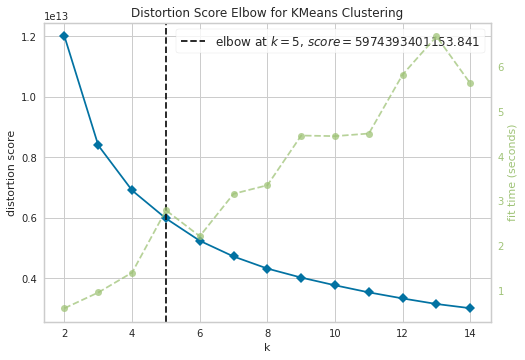

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
# fit vectors BERT
vis.fit(VECTORS)
# finalize and render the figure
vis.show()

In [32]:
NUM_CLUSTER = 5 # maximum likelihood

In [33]:
kmeans_model = KMeans(n_clusters=NUM_CLUSTER, init='k-means++', max_iter=100, n_init=1)
kmeans_model.fit(TOKENS)

KMeans(max_iter=100, n_clusters=5, n_init=1)

In [34]:
pickle.dump(kmeans_model, open(f'EECSI_kmeans_model.pickle', 'wb'))

In [35]:
x1 = VECTORS[:,0]
x2 = VECTORS[:,1]
x3 = VECTORS[:,2]
print(x1)
print(x2)
print(x3)

[  5988.5033483   -9400.03492064  -8864.10880815 ...  16494.51647747
  21016.16572636 -13330.36689486]
[-7956.72323972 -3560.01329304  5499.84447553 ... -8689.82502047
  -778.63363669  2970.52105554]
[-11177.21421841  13814.54945488  -9154.51386531 ...   4357.58554297
   9100.16466913  -1687.39852074]


In [36]:
# b: blue, g: green, r: red, c: cyan, m: magenta, y: yellow, k: black, w: white
# o: circle, v: triangle_down, s: square, h: hexagon1, d: thin_diamond, *: star
COLORS = ['b', 'c', 'g', 'r', 'y', 'k']
MARKERS = ['o', 'v', 's', 'h', 'd', '*']

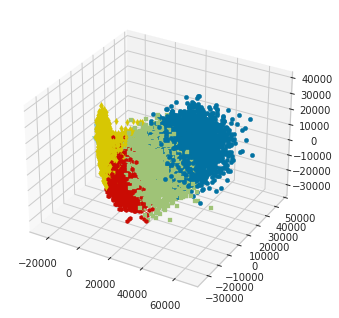

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, l in enumerate(kmeans_model.labels_):
  ax.scatter(x1[i], x2[i], x3[i], color=COLORS[l], marker=MARKERS[l], ls='None')

plt.savefig(f'EECSI_cluster.png', format='png', dpi=300)
plt.show()

In [38]:
df['Cluster'] = kmeans_model.labels_
df[['Cleaned','Cluster']].head()

,Cleaned,Cluster
Id,,
34552656,java repeat task every random second pim alrea...,3
34553034,java optionals immutable pid like understand j...,4
34553174,text overlay image darken opacity react native...,1
34553318,ternary operator swift picky pthe question sim...,3
34553755,hideshow fab scale animation pim use custom fl...,0


**Cluster Validation with BERT Classification**

In [39]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.initializers import TruncatedNormal
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.layers import Input, Dense, Dropout
from sklearn.model_selection import train_test_split

In [40]:
# split input_ids
X_train, X_val, y_train, y_val = train_test_split(TOKENS.numpy(), df['Cluster'], test_size=0.25, random_state=42)

In [41]:
# split attention_mask
train_mask, val_mask, _, _ = train_test_split(encoding['attention_mask'].numpy(), df['Cluster'], test_size=0.25, random_state=42)

In [42]:
print(y_val.shape)
print(y_train.shape)

(15000,)
(45000,)


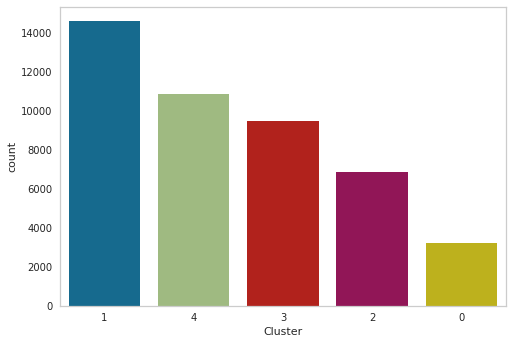

In [43]:
# show balance of train label
ax1 = sns.countplot(x=y_train, order=y_train.value_counts().index)
plt.grid(False)
plt.savefig(f'EECSI_train_label.png', format='png', dpi=300)
plt.show()

In [44]:
bert = TFBertModel.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/86.8M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/paraphrase-MiniLM-L6-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [45]:
input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

In [46]:
embeddings = bert(input_ids, attention_mask=input_mask)[0] 

In [47]:
from keras.regularizers import l1, l2
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = Dropout(0.3)(out)
out = Dense(64, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), activation='relu')(out)
out = Dropout(0.2)(out)
out = Dense(32, activation='relu')(out)
out = Dropout(0.1)(out)
y = Dense(5, activation='softmax')(out)

In [48]:
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

In [49]:
model.layers

In [50]:
model.layers[2].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 22713216    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 384)          0           tf_bert_model[0][0]          

In [51]:
OPTIMIZER = tf.keras.optimizers.Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
LOSS = CategoricalCrossentropy(from_logits=False)
METRIC = CategoricalAccuracy('accuracy'),
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRIC)

In [52]:
# callback
VAL_ACCURACY_THRESHOLD = 0.97
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if(logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= VAL_ACCURACY_THRESHOLD):
            print('Reached {} accuracy, stop training!'.format(VAL_ACCURACY_THRESHOLD))
            self.model.stop_training = True

In [53]:
MODELPATH = f'bert_classification.h5'
CHECKPOINT = ModelCheckpoint(MODELPATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)
EARLY_STOPPING = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
CALBACKS_LIST = [CHECKPOINT, EARLY_STOPPING, myCallback()]

In [54]:
# one hot encoding
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
train_label = lb.fit_transform(y_train)
val_label = lb.transform(y_val)

In [55]:
print(train_label.shape)
print(val_label.shape)

(45000, 5)
(15000, 5)


In [56]:
# fitting
EPOCH = 30
BATCH_SIZE = 40
history = model.fit(
    x = {'input_ids':X_train, 'attention_mask':train_mask},
    y = train_label,
    validation_data = ({'input_ids':X_val,'attention_mask':val_mask}, val_label),
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    callbacks=CALBACKS_LIST
    )

2022-08-06 12:21:26.481994: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
1125/1125 [==============================] - 256s 221ms/step - loss: 0.9217 - accuracy: 0.6585 - val_loss: 0.6238 - val_accuracy: 0.7949

Epoch 00001: val_accuracy improved from -inf to 0.79487, saving model to bert_classification.h5
Epoch 2/30
1125/1125 [==============================] - 265s 236ms/step - loss: 0.6846 - accuracy: 0.7713 - val_loss: 0.5682 - val_accuracy: 0.8177

Epoch 00002: val_accuracy improved from 0.79487 to 0.81773, saving model to bert_classification.h5
Epoch 3/30
1125/1125 [==============================] - 248s 220ms/step - loss: 0.6249 - accuracy: 0.8006 - val_loss: 0.5290 - val_accuracy: 0.8333

Epoch 00003: val_accuracy improved from 0.81773 to 0.83327, saving model to bert_classification.h5
Epoch 4/30
1125/1125 [==============================] - 265s 236ms/step - loss: 0.6004 - accuracy: 0.8109 - val_loss: 0.5103 - val_accuracy: 0.8423

Epoch 00004: val_accuracy improved from 0.83327 to 0.84227, saving model to bert_classification.h5
Epoch 5/30


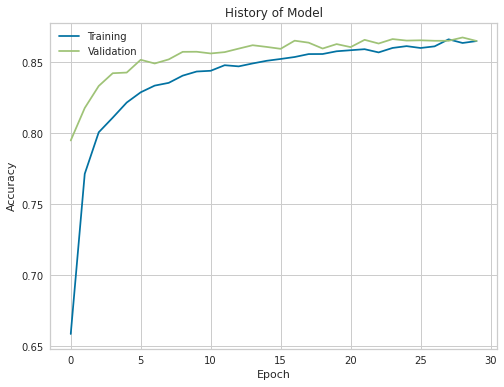

In [57]:
# plot loss and accuracy
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('History of Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig(f'EECSI_history.png', format='png', dpi=300)
plt.show()

In [58]:
predicted_raw = model.predict({'input_ids':X_val,'attention_mask':val_mask})
predicted_raw[0]

array([0.46376383, 0.00514571, 0.5223519 , 0.00419232, 0.00454624],
      dtype=float32)

In [59]:
from sklearn.metrics import classification_report

pred = np.argmax(predicted_raw, axis=1)
ground = np.argmax(val_label, axis=1)

In [60]:
# report accuration
import warnings
warnings.filterwarnings('ignore')
print(classification_report(ground, pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1063
           1       0.92      0.91      0.91      4907
           2       0.84      0.89      0.87      2227
           3       0.79      0.87      0.83      3184
           4       0.87      0.76      0.81      3619

    accuracy                           0.86     15000
   macro avg       0.86      0.88      0.87     15000
weighted avg       0.87      0.86      0.86     15000



# Likelihood of Occurring

In [61]:
# count by Cluster
CLS = df.groupby(['Cluster'])['Cluster'].count().to_frame()
CLS

,Cluster
Cluster,
0,4271
1,19503
2,9090
3,12674
4,14462


In [62]:
CLS = CLS.rename(columns={CLS.columns[0]: 'Units'})
CLS

,Units
Cluster,
0,4271
1,19503
2,9090
3,12674
4,14462


In [63]:
CLS['Rank'] = CLS['Units'].rank().astype(int)
CLS

,Units,Rank
Cluster,,
0,4271,1
1,19503,5
2,9090,2
3,12674,3
4,14462,4


In [64]:
# likelihood function 
def likelihood(cluster, maxi):
    rank = CLS.query('Cluster == @cluster').Rank
    rank = int(rank)
    if rank >= maxi:
        return maxi
    else:
        return rank


In [65]:
likelihood(4, 5)

4

In [66]:
df['Likelihood'] = df.apply(lambda x: likelihood(x['Cluster'], 5), axis=1)
df[['Cleaned','Cluster','Likelihood']].head()

,Cleaned,Cluster,Likelihood
Id,,,
34552656,java repeat task every random second pim alrea...,3,3
34553034,java optionals immutable pid like understand j...,4,4
34553174,text overlay image darken opacity react native...,1,5
34553318,ternary operator swift picky pthe question sim...,3,3
34553755,hideshow fab scale animation pim use custom fl...,0,1


# Sentiment Analysis

In [67]:
from textblob import TextBlob

In [68]:
print(df.iloc[1]['Cleaned'])
print(TextBlob(df.iloc[1]['Cleaned']).sentiment.polarity)

java optionals immutable pid like understand java  optionals design immutable threadsafetyp
0.0


In [69]:
df['Sentiment'] = df['Cleaned'].apply(lambda x : TextBlob(x).sentiment.polarity)

In [70]:
df[['Cleaned','Sentiment']].head()

,Cleaned,Sentiment
Id,,
34552656,java repeat task every random second pim alrea...,-0.03125
34553034,java optionals immutable pid like understand j...,0.00000
34553174,text overlay image darken opacity react native...,0.00000
34553318,ternary operator swift picky pthe question sim...,0.00000
34553755,hideshow fab scale animation pim use custom fl...,0.00000


In [71]:
# get median of positive sentiment
med_positive = df[df['Sentiment'] > 0].Sentiment.median()
print(med_positive)
print(df[df['Sentiment'] >= med_positive].Sentiment.count())
print(df[df['Sentiment'] > 0].Sentiment.count())

0.19564393939393937
9210
18420


In [72]:
# get median of negative sentiment
med_negative = df[df['Sentiment'] < 0].Sentiment.median()
print(med_negative)
print(df[df['Sentiment'] <= med_negative].Sentiment.count())
print(df[df['Sentiment'] < 0].Sentiment.count())

-0.1875
5031
9969


In [73]:
def serverity_impact(sentiment):
    if sentiment == 0:
        return 3
    elif sentiment <= med_negative:
        return 5
    elif sentiment < 0:
        return 4
    elif sentiment >= med_positive:
        return 1
    else:
        return 2

In [74]:
df['Severity'] = df['Sentiment'].apply(serverity_impact)

In [75]:
df[['Cleaned','Severity']].head()

,Cleaned,Severity
Id,,
34552656,java repeat task every random second pim alrea...,4
34553034,java optionals immutable pid like understand j...,3
34553174,text overlay image darken opacity react native...,3
34553318,ternary operator swift picky pthe question sim...,3
34553755,hideshow fab scale animation pim use custom fl...,3


In [76]:
df['Severity'].value_counts().index.tolist()

[3, 2, 1, 5, 4]

In [77]:
mylabels = ['Medium Impact','Low Impact','Less Impact','Very High Impact','High Impact']

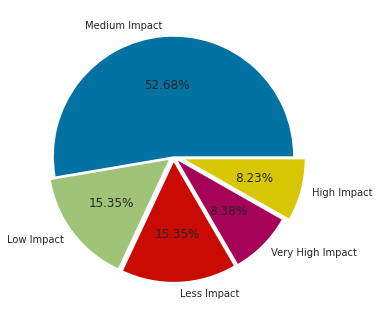

In [78]:
y = np.array(df['Severity'].value_counts()[:].tolist())
myexplode = [0, 0.05, 0.05, 0.05, 0.1]

plt.pie(y, labels=mylabels, explode=myexplode, autopct='%1.2f%%')
plt.savefig(f'EECSI_impact_chart.png', format='png', dpi=300)
plt.show()

In [79]:
risk_matrix = df.groupby(['Severity', 'Likelihood']).size().reset_index(name='Matrix')
risk_matrix

,Severity,Likelihood,Matrix
0,1,1,375
1,1,2,1111
2,1,3,1852
3,1,4,2353
4,1,5,3519
5,2,1,362
6,2,2,1181
7,2,3,1874
8,2,4,2148
9,2,5,3645


In [80]:
risk_matrix.query('Severity == 1 & Likelihood == 1').Matrix.values[0]

375

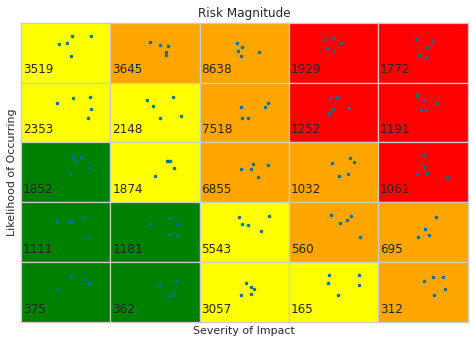

In [81]:
fig = plt.figure()
plt.subplots_adjust(wspace=0, hspace=0)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('Severity of Impact')
plt.ylabel('Likelihood of Occurring')
plt.title('Risk Magnitude')

# 5 * 5 matrix
nrows = 5
ncols = 5
axes = [fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

# remove the x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0,5)
    ax.set_ylim(0,5)

# add background colors
green = [10, 15, 16, 20 , 21] 
yellow = [0, 5, 6, 11, 17, 22, 23] 
orange = [1 , 2, 7, 12, 13, 18, 19, 24] 
red = [3, 4, 8, 9, 14]

for _ in green:
    axes[_].set_facecolor('green')

for _ in yellow:
    axes[_].set_facecolor('yellow')

for _ in orange:
    axes[_].set_facecolor('orange')

for _ in red:
    axes[_].set_facecolor('red')


# add labels to the Green boxes
axes[10].text(0.1,0.8, risk_matrix.query('Severity == 1 & Likelihood == 3').Matrix.values[0])
axes[15].text(0.1,0.8, risk_matrix.query('Severity == 1 & Likelihood == 2').Matrix.values[0])
axes[20].text(0.1,0.8, risk_matrix.query('Severity == 1 & Likelihood == 1').Matrix.values[0])
axes[16].text(0.1,0.8, risk_matrix.query('Severity == 2 & Likelihood == 2').Matrix.values[0])
axes[21].text(0.1,0.8, risk_matrix.query('Severity == 2 & Likelihood == 1').Matrix.values[0])


# add labels to the Yellow boxes
axes[0].text(0.1,0.8, risk_matrix.query('Severity == 1 & Likelihood == 5').Matrix.values[0])
axes[5].text(0.1,0.8, risk_matrix.query('Severity == 1 & Likelihood == 4').Matrix.values[0])
axes[6].text(0.1,0.8, risk_matrix.query('Severity == 2 & Likelihood == 4').Matrix.values[0])
axes[11].text(0.1,0.8, risk_matrix.query('Severity == 2 & Likelihood == 3').Matrix.values[0])
axes[17].text(0.1,0.8, risk_matrix.query('Severity == 3 & Likelihood == 2').Matrix.values[0])
axes[22].text(0.1,0.8, risk_matrix.query('Severity == 3 & Likelihood == 1').Matrix.values[0])
axes[23].text(0.1,0.8, risk_matrix.query('Severity == 4 & Likelihood == 1').Matrix.values[0])

# add lables to the Orange boxes
axes[1].text(0.1,0.8, risk_matrix.query('Severity == 2 & Likelihood == 5').Matrix.values[0])
axes[2].text(0.1,0.8, risk_matrix.query('Severity == 3 & Likelihood == 5').Matrix.values[0])
axes[7].text(0.1,0.8, risk_matrix.query('Severity == 3 & Likelihood == 4').Matrix.values[0])
axes[12].text(0.1,0.8, risk_matrix.query('Severity == 3 & Likelihood == 3').Matrix.values[0])
axes[13].text(0.1,0.8, risk_matrix.query('Severity == 4 & Likelihood == 3').Matrix.values[0])
axes[18].text(0.1,0.8, risk_matrix.query('Severity == 4 & Likelihood == 2').Matrix.values[0])
axes[19].text(0.1,0.8, risk_matrix.query('Severity == 5 & Likelihood == 2').Matrix.values[0])
axes[24].text(0.1,0.8, risk_matrix.query('Severity == 5 & Likelihood == 1').Matrix.values[0])

# add lables to the Red Boxes
axes[3].text(0.1,0.8, risk_matrix.query('Severity == 4 & Likelihood == 5').Matrix.values[0])
axes[8].text(0.1,0.8, risk_matrix.query('Severity == 4 & Likelihood == 4').Matrix.values[0])
axes[4].text(0.1,0.8, risk_matrix.query('Severity == 5 & Likelihood == 5').Matrix.values[0])
axes[9].text(0.1,0.8, risk_matrix.query('Severity == 5 & Likelihood == 4').Matrix.values[0])
axes[14].text(0.1,0.8, risk_matrix.query('Severity == 5 & Likelihood == 3').Matrix.values[0])

# plot some data
for _ in range(len(axes)):
    axes[_].plot(np.random.uniform(2,4,5), np.random.uniform(2,4,5), '.')
        
plt.savefig(f'EECSI_risk-matrix.png', format='png', dpi=300)
plt.show()

In [82]:
PRIORITIES = ['Small', 'Medium', 'High', 'Extreme']

In [83]:
def priority(serve, likeli):
    if serve == 1 and likeli in [1, 2, 3]:
        return PRIORITIES[0]
    if serve == 2 and likeli in [1, 2]:
        return PRIORITIES[0]
    if serve == 1 and likeli in [4, 5]:
        return PRIORITIES[1]
    if serve == 2 and likeli in [3, 4]:
        return PRIORITIES[1]
    if serve == 3 and likeli in [1, 2]:
        return PRIORITIES[1]
    if serve == 4 and likeli == 1:
        return PRIORITIES[1]
    if serve == 2 and likeli == 5:
        return PRIORITIES[2]
    if serve == 3 and likeli in [3, 4, 5]:
        return PRIORITIES[2]
    if serve == 4 and likeli in [2, 3]:
        return PRIORITIES[2]
    if serve == 5 and likeli == 1:
        return PRIORITIES[2]
    else:
        return PRIORITIES[3]

In [84]:
print(priority(5, 2))

Extreme


In [85]:
df['Priority'] = df.apply(lambda x: priority(x['Severity'],x['Likelihood']), axis=1)

In [86]:
df[['Text','Cluster','Likelihood','Sentiment','Severity','Priority']].head(10)

,Text,Cluster,Likelihood,Sentiment,Severity,Priority
Id,,,,,,
34552656,Java: Repeat Task Every Random Seconds <p>I'm ...,3,3,-0.031250,4,High
34553034,Why are Java Optionals immutable? <p>I'd like ...,4,4,0.000000,3,High
34553174,Text Overlay Image with Darkened Opacity React...,1,5,0.000000,3,High
34553318,Why ternary operator in swift is so picky? <p>...,3,3,0.000000,3,High
34553755,hide/show fab with scale animation <p>I'm usin...,0,1,0.000000,3,Medium
34554026,Accessing pointer member of the structure usin...,4,4,0.000000,3,High
34554206,"How To Disable 2nd Saturday 4th Saturday ,Sund...",1,5,0.000000,3,High
34554671,Resizing containers in bootstrap I am new to b...,1,5,0.178788,2,High
34554871,Changing Theme in Windows 10 UWP App Programma...,3,3,0.350000,1,Small


In [87]:
pickle.dump(df, open(f'EECSI_df.pickle', 'wb'))

In [88]:
# load object to continue after end session
#PK = open(f'EECSI_df.pickle','rb')
#df = pickle.load(PK)
#PK.close()

In [89]:
df

,Y,Text,Words,Cleaned,Cluster,Likelihood,Sentiment,Severity,Priority
Id,,,,,,,,,
34552656,LQ_CLOSE,Java: Repeat Task Every Random Seconds <p>I'm ...,60,java repeat task every random second pim alrea...,3,3,-0.031250,4,High
34553034,HQ,Why are Java Optionals immutable? <p>I'd like ...,23,java optionals immutable pid like understand j...,4,4,0.000000,3,High
34553174,HQ,Text Overlay Image with Darkened Opacity React...,408,text overlay image darken opacity react native...,1,5,0.000000,3,High
34553318,HQ,Why ternary operator in swift is so picky? <p>...,116,ternary operator swift picky pthe question sim...,3,3,0.000000,3,High
34553755,HQ,hide/show fab with scale animation <p>I'm usin...,35,hideshow fab scale animation pim use custom fl...,0,1,0.000000,3,Medium
...,...,...,...,...,...,...,...,...,...
60465681,LQ_CLOSE,How can I align two flex boxes to follow each ...,87,align two flex box follow pi menu id like divr...,2,2,0.000000,3,Medium
60467932,LQ_CLOSE,C++ The correct way to multiply an integer and...,145,c correct way multiply integer double pi try m...,4,4,-0.100000,4,Extreme
60468378,LQ_EDIT,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,142,django show error try open new page hyperlink ...,2,2,0.068182,2,Small


In [90]:
my_colors = ['#FFA500','#FFFF00','#FF0000','#00FF00']
print(df['Priority'].value_counts().index)

Index(['High', 'Medium', 'Extreme', 'Small'], dtype='object')


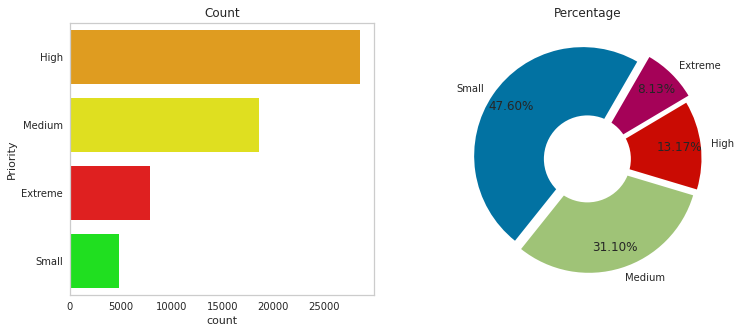

In [91]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
explode = [0.05, 0.05, 0.05, 0.1]
sizes = df['Priority'].value_counts()[:]
sns.set_palette(my_colors)

ax2.pie(sizes, explode=explode, labels=PRIORITIES, startangle=60, autopct='%1.2f%%', pctdistance=0.8)
ax2.add_artist(plt.Circle((0,0),0.4,fc='white'))
sns.countplot(y='Priority', data=df, ax=ax1, order=df['Priority'].value_counts().index)
ax1.grid(False)
ax1.set_title("Count")
ax2.set_title("Percentage")
plt.savefig(f'EECSI_priority_chart.png', format='png', dpi=300)
plt.show()

# Compare to other research

In [92]:
# prediction issue from (Hammad, 2018)
# DOI:10.1109/FIT.2018.00035
risks = [
    ['exception handling', 'High'],
    ['hardware failure risk', 'Medium'],
    ['code consistency between development team', 'Small'],
    ['Lack of team expertise', 'Medium'],
    ['database security', 'Medium'],
    ['storage media exposure', 'Medium'],
    ['developer unavailability', 'Small'],
    ['unauthorized login', 'Small'] 
    ]

In [93]:
df_risk = pd.DataFrame(risks, columns=['risk', 'priority'])
df_risk

,risk,priority
0,exception handling,High
1,hardware failure risk,Medium
2,code consistency between development team,Small
3,Lack of team expertise,Medium
4,database security,Medium
5,storage media exposure,Medium
6,developer unavailability,Small
7,unauthorized login,Small


In [94]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

class RiskMatrix:
    def __init__(self, sentence):
        self.sentence = sentence
        self.cleaned = cleaned(self.sentence)
        #tokenize
        encd = tokenizer(
            text=[self.cleaned],
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=MAX_LEN,
            truncation=True,
            pad_to_max_length=True,
            return_tensors='tf',
            verbose=True
        )
        # predict likelihood
        token = encd['input_ids']
        self.cluster = int(kmeans_model.predict(token))  
        self.likelihood = likelihood(self.cluster, 5) # with 5 scale
        # predict severity
        sentiment = TextBlob(self.cleaned).sentiment.polarity
        self.severity = serverity_impact(sentiment)
    # risk prediction
    def prediction():
        return RiskMatrix()

In [95]:
def get_cluster(sentence):
    rm = RiskMatrix(sentence)
    return rm.cluster

In [96]:
def get_severity(sentence):
    rm = RiskMatrix(sentence)
    return rm.severity

def get_likelihood(sentence):
    rm = RiskMatrix(sentence)
    return rm.likelihood
  

In [97]:
def get_priority(sentence):
    rm = RiskMatrix(sentence)
    return priority(rm.severity, rm.likelihood)

In [98]:
df_risk['cluster'] = df_risk['risk'].apply(get_cluster)
df_risk['severity'] = df_risk['risk'].apply(get_severity)
df_risk['likelihood'] = df_risk['risk'].apply(get_likelihood)
df_risk['prediction'] = df_risk['risk'].apply(get_priority)
df_risk

,risk,priority,cluster,severity,likelihood,prediction
0,exception handling,High,1,3,5,High
1,hardware failure risk,Medium,1,5,5,Extreme
2,code consistency between development team,Small,1,3,5,High
3,Lack of team expertise,Medium,1,3,5,High
4,database security,Medium,1,3,5,High
5,storage media exposure,Medium,1,3,5,High
6,developer unavailability,Small,1,3,5,High
7,unauthorized login,Small,1,3,5,High
